In [1]:
# Imports
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import optuna
import pandas as pd





/home/yujin31/.conda/envs/cs336_data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
###First Optuna Finetuning Best Result

# best_lr = 0.00010105772862798898
# best_dropout = 0.2764855698963228
# best_weight_decay = 0.006334399635390254
# best_batch_size = 8
# best_epochs = 14
# Best hyperparameters: {'lr': 0.00010105772862798898, 'dropout': 0.2764855698963228, 'batch_size': 8, 'weight_decay': 0.006334399635390254, 'conv1_out': 64, 'conv2_out': 64, 'conv3_out': 128, 'optimizer': 'AdamW', 'epochs': 14}

###Second Optuna Finetuning Best Result
best_lr = 0.00036389815664587447
best_dropout = 0.34455701593254945
best_weight_decay = 0.005790631941119515
best_batch_size = 64
best_epochs = 18
#Best hyperparameters: {'lr': 0.00036389815664587447, 'dropout': 0.34455701593254945, 'batch_size': 64, 'weight_decay': 0.005790631941119515, 'conv1_out': 128, 'conv2_out': 256, 'conv3_out': 512, 'optimizer': 'AdamW', 'epochs': 18}


In [40]:


# Transform: normalize images to [0, 1]
transform = transforms.Compose([transforms.ToTensor()])

# Load FashionMNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training into train + validation
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_set, val_set = random_split(train_dataset, [train_len, val_len])



# Dataloaders
train_loader = DataLoader(train_set, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

In [ ]:
#Ablation Study. Augmentation data

# Data augmentation for training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),     # Random horizontal flip
    transforms.RandomRotation(degrees=10),      # Random small rotation
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))         # Normalize to [-1, 1]
])

# Standard transform for validation/test sets
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset with transforms
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Split training into train + validation
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_set, val_set = random_split(train_dataset, [train_len, val_len])

# Apply test transform to validation set
val_set.dataset.transform = test_transform 

# Dataloaders
train_loader = DataLoader(train_set, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)


In [8]:
# Model class
class SimpleCNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, conv3_out, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out , kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(conv3_out * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Optimizer with best learning rate
model = SimpleCNN(conv1_out=128, conv2_out=256, conv3_out=512, dropout=best_dropout)


In [ ]:
#Ablation Study. Normalization
class SimpleCNN(nn.Module):
    def __init__(self, conv1_out, conv2_out, conv3_out, dropout):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(conv1_out, conv2_out , kernel_size=7, padding=3)
        self.conv3 = nn.Conv2d(conv2_out, conv3_out, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm2d(conv3_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(conv3_out * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Optimizer with best learning rate
model = SimpleCNN(conv1_out=128, conv2_out=256, conv3_out=512, dropout=best_dropout)



In [42]:

optimizer = optim.AdamW(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

criterion = nn.CrossEntropyLoss()


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')
patience = 3
trigger_times = 0

for epoch in range(best_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break



Epoch 1, Train Loss: 0.5615, Train Acc: 80.11%, Val Loss: 0.3416, Val Acc: 87.00%
Epoch 2, Train Loss: 0.3262, Train Acc: 88.56%, Val Loss: 0.2797, Val Acc: 89.23%
Epoch 3, Train Loss: 0.2655, Train Acc: 90.56%, Val Loss: 0.2437, Val Acc: 90.67%
Epoch 4, Train Loss: 0.2311, Train Acc: 91.94%, Val Loss: 0.2440, Val Acc: 90.95%
Early stopping trigger count: 1
Epoch 5, Train Loss: 0.1988, Train Acc: 92.86%, Val Loss: 0.2396, Val Acc: 91.47%
Epoch 6, Train Loss: 0.1732, Train Acc: 93.87%, Val Loss: 0.2520, Val Acc: 91.67%
Early stopping trigger count: 1
Epoch 7, Train Loss: 0.1488, Train Acc: 94.69%, Val Loss: 0.2702, Val Acc: 91.81%
Early stopping trigger count: 2
Epoch 8, Train Loss: 0.1264, Train Acc: 95.38%, Val Loss: 0.2828, Val Acc: 91.41%
Early stopping trigger count: 3
Early stopping triggered.


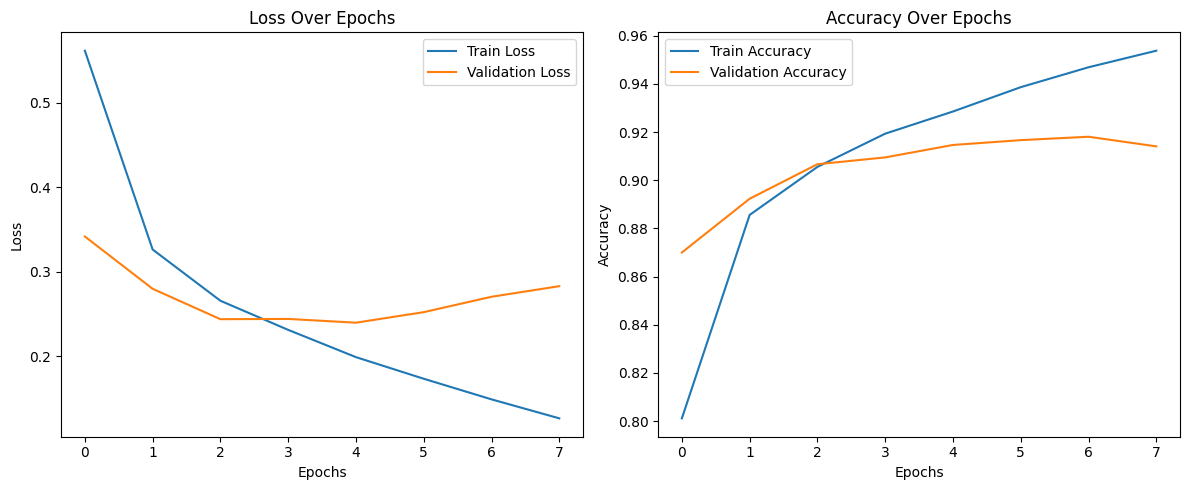

In [44]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9092


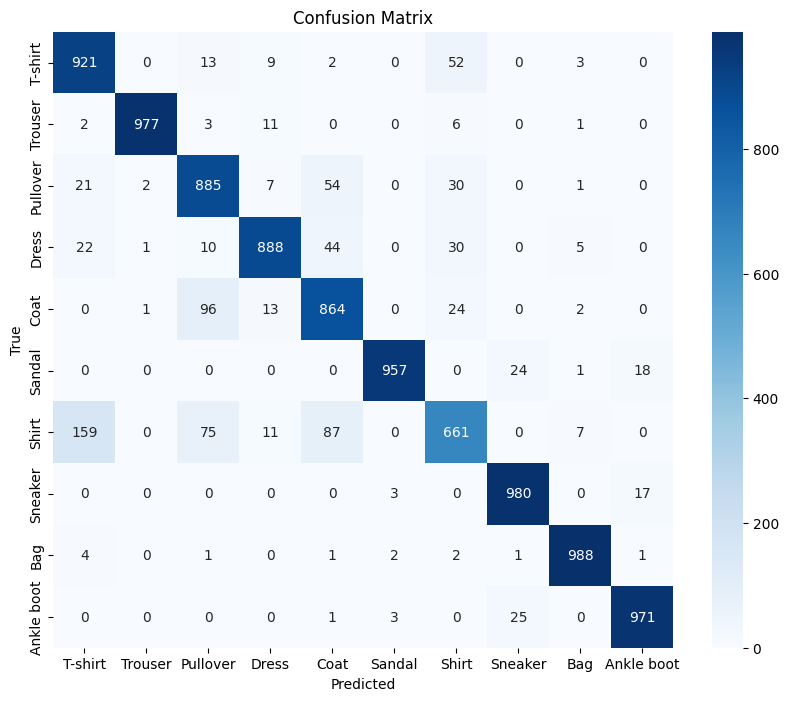

In [45]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification metrics table
TPR, FPR, FNR, TNR = [], [], [], []
num_classes = cm.shape[0]

for i in range(num_classes):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    TPR.append(TP / (TP + FN + 1e-6))
    FPR.append(FP / (FP + TN + 1e-6))
    FNR.append(FN / (TP + FN + 1e-6))
    TNR.append(TN / (TN + FP + 1e-6))

# Per-class metrics DataFrame
metrics_df = pd.DataFrame({
    'Class': labels,
    'TPR (Recall)': TPR,
    'FPR': FPR,
    'FNR': FNR,
    'TNR': TNR
})

# Overall metrics
overall_accuracy = accuracy_score(all_labels, all_preds)
macro_precision = precision_score(all_labels, all_preds, average='macro')
macro_recall = recall_score(all_labels, all_preds, average='macro')
macro_f1 = f1_score(all_labels, all_preds, average='macro')

print(metrics_df.to_string(index=False))
print("\nOverall Metrics:")
print(f"Accuracy      : {overall_accuracy:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall   : {macro_recall:.4f}")
print(f"Macro F1-score : {macro_f1:.4f}")


     Class  TPR (Recall)      FPR   FNR      TNR
   T-shirt         0.921 0.023111 0.079 0.976889
   Trouser         0.977 0.000444 0.023 0.999556
  Pullover         0.885 0.022000 0.115 0.978000
     Dress         0.888 0.005667 0.112 0.994333
      Coat         0.864 0.021000 0.136 0.979000
    Sandal         0.957 0.000889 0.043 0.999111
     Shirt         0.661 0.016000 0.339 0.984000
   Sneaker         0.980 0.005556 0.020 0.994444
       Bag         0.988 0.002222 0.012 0.997778
Ankle boot         0.971 0.004000 0.029 0.996000

Overall Metrics:
Accuracy      : 0.9092
Macro Precision: 0.9104
Macro Recall   : 0.9092
Macro F1-score : 0.9083


In [ ]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 5e-5, 5e-4, log=True)
#     dropout_rate = trial.suggest_float("dropout", 0.2, 0.35)
#     batch_size = trial.suggest_categorical("batch_size", [4 ,8, 16, 32, 64])
#     weight_decay = trial.suggest_float("weight_decay", 5e-3, 1e-2, log=True)
#     conv1_out = trial.suggest_categorical("conv1_out", [16, 32, 64, 128])
#     conv2_out = trial.suggest_categorical("conv2_out", [32, 64, 128, 256])
#     conv3_out = trial.suggest_categorical("conv3_out", [64, 128, 256,512])
#     optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
#     n_epochs = trial.suggest_int("epochs", 10, 20, step=1)


#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = SimpleCNN(conv1_out, conv2_out, conv3_out, dropout=dropout_rate).to(device)
#     criterion = nn.CrossEntropyLoss()

#     if optimizer_name == "Adam":
#         optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     elif optimizer_name == "AdamW":
#         optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     elif optimizer_name == "SGD":
#         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
#     else:
#         optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

#     for epoch in range(n_epochs):
#         model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             loss = criterion(model(images), labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)
#             correct += (preds == labels).sum().item()
#             total += labels.size(0)

#     return correct / total


In [ ]:
# import optuna
# import json

# # Run the hyperparameter optimization study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters to the console
# print("Best hyperparameters:", study.best_params)

# # Save the best hyperparameters to a text file (JSON format)
# with open("best_hyperparameters.txt", "w") as f:
#     f.write("Best hyperparameters:\n")
#     f.write(json.dumps(study.best_params, indent=4))

# # Prepare a list to hold all trial data
# trials_data = []
# for trial in study.trials:
#     trial_dict = {
#         "trial_number": trial.number,
#         "value": trial.value,
#         "params": trial.params,
#         "state": trial.state.name,
#         "datetime_start": trial.datetime_start.isoformat() if trial.datetime_start is not None else None,
#         "datetime_complete": trial.datetime_complete.isoformat() if trial.datetime_complete is not None else None,
#         "user_attrs": trial.user_attrs,
#         "system_attrs": trial.system_attrs
#     }
#     trials_data.append(trial_dict)

# # Save all trial data to a text file in JSON format
# with open("all_trials.txt", "w") as f:
#     json.dump(trials_data, f, indent=4)

# print("All trial data saved to best_hyperparameters.txt and all_trials.txt")


[I 2025-04-13 11:56:31,471] A new study created in memory with name: no-name-8c444062-c4e6-4c62-9af9-dcdb483e45c6
[I 2025-04-13 11:57:45,342] Trial 0 finished with value: 0.931 and parameters: {'lr': 9.841835381208791e-05, 'dropout': 0.2491730387795211, 'batch_size': 16, 'weight_decay': 0.00572545588223569, 'conv1_out': 128, 'conv2_out': 128, 'conv3_out': 128, 'optimizer': 'AdamW', 'epochs': 13}. Best is trial 0 with value: 0.931.
[I 2025-04-13 11:58:52,277] Trial 1 finished with value: 0.9305833333333333 and parameters: {'lr': 0.00044821477011397135, 'dropout': 0.3457713411651214, 'batch_size': 32, 'weight_decay': 0.006239434288978878, 'conv1_out': 128, 'conv2_out': 256, 'conv3_out': 512, 'optimizer': 'AdamW', 'epochs': 19}. Best is trial 0 with value: 0.931.
[I 2025-04-13 11:59:34,036] Trial 2 finished with value: 0.92225 and parameters: {'lr': 0.00016810614244788281, 'dropout': 0.3216974782425456, 'batch_size': 64, 'weight_decay': 0.00764511362093005, 'conv1_out': 128, 'conv2_out': 

Best hyperparameters: {'lr': 0.00036389815664587447, 'dropout': 0.34455701593254945, 'batch_size': 64, 'weight_decay': 0.005790631941119515, 'conv1_out': 128, 'conv2_out': 256, 'conv3_out': 512, 'optimizer': 'AdamW', 'epochs': 18}
All trial data saved to best_hyperparameters.txt and all_trials.txt


# All Optuna #1 Trials – Hyperparameter Search Summary

Below is a table of all 50 Optuna trials showing validation accuracy and chosen hyperparameters.  
The best trial (Trial 21) is highlighted.

---

| Trial | Accuracy (%) | LR         | Dropout | Batch Size | Weight Decay | Conv1 | Conv2 | Conv3 | Optimizer | Epochs |
|-------|--------------|------------|---------|-------------|---------------|--------|--------|--------|-----------|--------|
| 0     | 87.96        | 1.52e-05   | 0.2342  | 256         | 7.47e-04      | 32     | 128    | 128    | AdamW     | 5      |
| 1     | 92.08        | 2.64e-04   | 0.5211  | 512         | 1.72e-03      | 16     | 128    | 64     | Adam      | 12     |
| 2     | 81.73        | 1.50e-05   | 0.3941  | 64          | 1.34e-06      | 16     | 64     | 128    | SGD       | 16     |
| 3     | 89.79        | 2.32e-03   | 0.5901  | 512         | 1.88e-03      | 32     | 128    | 256    | RMSprop   | 21     |
| 4     | 92.30        | 9.44e-03   | 0.5290  | 16          | 3.32e-06      | 16     | 32     | 128    | SGD       | 20     |
| 5     | 91.34        | 1.49e-03   | 0.5164  | 32          | 7.36e-04      | 64     | 128    | 128    | Adam      | 7      |
| 6     | 91.26        | 4.66e-04   | 0.1883  | 128         | 1.90e-03      | 32     | 64     | 256    | RMSprop   | 5      |
| 7     | 92.19        | 3.51e-03   | 0.6486  | 256         | 2.46e-05      | 64     | 32     | 128    | Adam      | 22     |
| 8     | 86.99        | 1.07e-05   | 0.2903  | 8           | 1.23e-05      | 32     | 128    | 256    | SGD       | 6      |
| 9     | 91.76        | 1.34e-05   | 0.5053  | 32          | 5.51e-04      | 32     | 128    | 64     | AdamW     | 23     |
| 10    | 9.56         | 8.32e-03   | 0.7576  | 16          | 1.24e-06      | 16     | 32     | 128    | SGD       | 17     |
| 11    | 87.03        | 9.14e-03   | 0.7006  | 16          | 2.40e-05      | 64     | 32     | 128    | Adam      | 25     |
| 12    | 92.33        | 2.72e-03   | 0.6528  | 256         | 7.72e-06      | 64     | 32     | 128    | Adam      | 21     |
| 13    | 92.43        | 5.44e-04   | 0.3875  | 16          | 6.06e-06      | 64     | 32     | 128    | SGD       | 19     |
| 14    | 92.67        | 3.88e-04   | 0.3573  | 256         | 1.10e-04      | 64     | 32     | 128    | Adam      | 13     |
| 15    | 86.37        | 1.60e-04   | 0.3459  | 128         | 1.32e-04      | 64     | 32     | 64     | SGD       | 12     |
| 16    | 92.47        | 5.48e-05   | 0.1091  | 8           | 1.12e-04      | 64     | 32     | 128    | RMSprop   | 13     |
| 17    | 92.73        | 5.28e-05   | 0.1265  | 8           | 1.02e-04      | 64     | 64     | 128    | RMSprop   | 12     |
| 18    | 92.04        | 7.13e-05   | 0.1061  | 8           | 2.73e-04      | 64     | 64     | 256    | RMSprop   | 9      |
| 19    | 91.68        | 4.82e-05   | 0.2026  | 64          | 4.25e-05      | 64     | 64     | 64     | RMSprop   | 10     |
| 20    | 92.89        | 1.20e-04   | 0.3017  | 8           | 5.64e-03      | 64     | 64     | 128    | AdamW     | 15     |
| 21  | **93.30**    | **1.01e-04** | **0.2765** | **8**   | **6.33e-03**  | **64** | **64** | **128** | **AdamW** | **14**  |
| 22    | 92.07        | 1.21e-04   | 0.2531  | 8           | 9.71e-03      | 64     | 64     | 128    | AdamW     | 15     |
| 23    | 91.83        | 3.15e-05   | 0.1608  | 8           | 9.11e-03      | 64     | 64     | 128    | AdamW     | 15     |
| 24    | 92.57        | 1.06e-04   | 0.3075  | 8           | 4.90e-03      | 64     | 64     | 128    | AdamW     | 10     |
| 25    | 92.59        | 2.66e-05   | 0.4303  | 8           | 4.25e-03      | 64     | 64     | 128    | AdamW     | 18     |
| 26    | 92.83        | 2.31e-04   | 0.2926  | 8           | 5.01e-03      | 64     | 64     | 128    | AdamW     | 14     |
| 27    | 92.81        | 2.24e-04   | 0.2856  | 8           | 5.05e-03      | 64     | 64     | 128    | AdamW     | 14     |
| 28    | 92.58        | 8.07e-04   | 0.4426  | 8           | 2.99e-03      | 64     | 64     | 256    | AdamW     | 17     |
| 29    | 92.48        | 1.63e-04   | 0.2512  | 8           | 3.39e-04      | 16     | 64     | 64     | AdamW     | 16     |
| 30    | 91.94        | 2.79e-05   | 0.3249  | 32          | 1.18e-03      | 32     | 64     | 128    | AdamW     | 9      |
| 31    | 92.03        | 3.19e-04   | 0.2813  | 8           | 6.89e-03      | 64     | 64     | 128    | AdamW     | 14     |
| 32    | 93.23        | 2.19e-04   | 0.2223  | 8           | 3.19e-03      | 64     | 64     | 128    | AdamW     | 14     |
| 33    | 91.68        | 8.87e-05   | 0.2165  | 512         | 3.40e-03      | 64     | 64     | 128    | AdamW     | 11     |
| 34    | 91.33        | 2.27e-04   | 0.1622  | 64          | 1.30e-03      | 16     | 64     | 128    | AdamW     | 15     |
| 35    | 91.63        | 9.06e-04   | 0.3891  | 512         | 2.23e-03      | 64     | 64     | 128    | AdamW     | 13     |
| 36    | 93.25        | 1.56e-04   | 0.2519  | 8           | 1.03e-03      | 64     | 64     | 128    | AdamW     | 17     |
| 37    | 91.98        | 1.64e-04   | 0.2431  | 128         | 7.69e-04      | 16     | 128    | 64     | AdamW     | 18     |
| 38    | 92.53        | 7.86e-05   | 0.1686  | 8           | 2.50e-03      | 32     | 64     | 256    | AdamW     | 16     |
| 39    | 93.03        | 6.24e-04   | 0.2230  | 64          | 1.64e-03      | 64     | 64     | 128    | AdamW     | 19     |
| 40    | 92.68        | 6.22e-04   | 0.2049  | 64          | 1.26e-03      | 64     | 128    | 128    | AdamW     | 20     |
| 41    | 92.73        | 3.41e-04   | 0.2426  | 64          | 5.65e-04      | 64     | 64     | 128    | AdamW     | 18     |
| 42    | 92.63        | 1.26e-04   | 0.3424  | 64          | 1.92e-03      | 64     | 64     | 128    | AdamW     | 17     |
| 43    | 92.46        | 1.23e-03   | 0.4865  | 32          | 6.67e-03      | 64     | 64     | 128    | AdamW     | 20     |
| 44    | 92.71        | 2.84e-04   | 0.1537  | 8           | 9.41e-04      | 64     | 64     | 128    | AdamW     | 19     |
| 45    | 92.24        | 4.63e-04   | 0.2643  | 64          | 3.36e-03      | 32     | 64     | 128    | AdamW     | 23     |
| 46    | 92.21        | 1.85e-04   | 0.2194  | 256         | 3.47e-04      | 64     | 128    | 256    | Adam      | 16     |
| 47    | 90.88        | 1.41e-03   | 0.5753  | 512         | 1.58e-03      | 16     | 64     | 128    | SGD       | 19     |
| 48    | 92.51        | 4.60e-03   | 0.3635  | 128         | 2.08e-04      | 64     | 64     | 128    | AdamW     | 15     |
| 49    | 92.18        | 4.08e-05   | 0.1870  | 16          | 7.40e-03      | 64     | 64     | 64     | AdamW     | 17     |
---


# All Optuna #2 Trials – Full Hyperparameter Search Summary

Below is the complete summary of all 100 Optuna trials after the first Optuna Trials. The best trial is **bolded**.

---

| Trial   | Accuracy (%)   | LR           | Dropout    | Batch Size   | Weight Decay   | Conv1   | Conv2   | Conv3   | Optimizer   | Epochs   |
|:--------|:---------------|:-------------|:-----------|:-------------|:---------------|:--------|:--------|:--------|:------------|:---------|
| 0       | 93.1           | 9.84e-05     | 0.2492     | 16           | 5.73e-03       | 128     | 128     | 128     | AdamW       | 13       |
| 1       | 93.06          | 4.48e-04     | 0.3458     | 32           | 6.24e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 2       | 92.22          | 1.68e-04     | 0.3217     | 64           | 7.65e-03       | 128     | 64      | 64      | AdamW       | 17       |
| 3       | 92.22          | 3.24e-04     | 0.2144     | 8            | 7.87e-03       | 16      | 32      | 64      | AdamW       | 19       |
| 4       | 92.31          | 1.03e-04     | 0.2613     | 64           | 5.53e-03       | 32      | 32      | 128     | AdamW       | 13       |
| 5       | 92.56          | 1.48e-04     | 0.27       | 4            | 8.43e-03       | 64      | 128     | 128     | AdamW       | 19       |
| 6       | 92.62          | 2.02e-04     | 0.3008     | 16           | 6.29e-03       | 32      | 64      | 128     | AdamW       | 14       |
| 7       | 92.97          | 1.93e-04     | 0.3012     | 8            | 5.93e-03       | 128     | 32      | 256     | AdamW       | 18       |
| 8       | 92.74          | 1.10e-04     | 0.3154     | 64           | 6.05e-03       | 128     | 32      | 256     | AdamW       | 10       |
| 9       | 93.33          | 7.87e-05     | 0.252      | 16           | 7.25e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 10      | 92.85          | 5.08e-05     | 0.2233     | 16           | 9.86e-03       | 64      | 256     | 512     | AdamW       | 16       |
| 11      | 92.87          | 5.54e-05     | 0.2421     | 16           | 5.24e-03       | 128     | 128     | 512     | AdamW       | 12       |
| 12      | 92.2           | 8.65e-05     | 0.2469     | 16           | 6.86e-03       | 16      | 256     | 128     | AdamW       | 15       |
| 13      | 93.05          | 7.39e-05     | 0.2029     | 16           | 6.98e-03       | 128     | 128     | 512     | AdamW       | 11       |
| 14      | 93.46          | 7.03e-05     | 0.2384     | 32           | 5.04e-03       | 128     | 256     | 128     | AdamW       | 15       |
| 15      | 92.94          | 6.87e-05     | 0.284      | 32           | 5.05e-03       | 128     | 256     | 512     | AdamW       | 16       |
| 16      | 92.98          | 1.32e-04     | 0.2318     | 32           | 8.79e-03       | 64      | 256     | 64      | AdamW       | 17       |
| 17      | 93.1           | 6.67e-05     | 0.2817     | 4            | 6.62e-03       | 32      | 256     | 256     | AdamW       | 15       |
| 18      | 92.68          | 2.32e-04     | 0.2603     | 32           | 7.47e-03       | 16      | 256     | 512     | AdamW       | 17       |
| 19      | 93.02          | 1.24e-04     | 0.2318     | 32           | 8.34e-03       | 128     | 256     | 128     | AdamW       | 20       |
| 20      | 92.76          | 8.98e-05     | 0.2008     | 8            | 9.27e-03       | 128     | 64      | 512     | AdamW       | 14       |
| 21      | 92.97          | 8.71e-05     | 0.2538     | 16           | 5.53e-03       | 128     | 128     | 128     | AdamW       | 13       |
| 22      | 92.88          | 6.24e-05     | 0.2433     | 16           | 5.60e-03       | 128     | 128     | 128     | AdamW       | 14       |
| 23      | 92.63          | 7.79e-05     | 0.2689     | 16           | 5.01e-03       | 128     | 128     | 128     | AdamW       | 12       |
| 24      | 93.12          | 1.09e-04     | 0.2298     | 4            | 5.77e-03       | 128     | 256     | 128     | AdamW       | 16       |
| 25      | 93.26          | 1.18e-04     | 0.2129     | 4            | 5.31e-03       | 128     | 256     | 128     | AdamW       | 16       |
| 26      | 92.47          | 5.73e-05     | 0.2173     | 4            | 5.28e-03       | 16      | 256     | 64      | AdamW       | 15       |
| 27      | 92.97          | 1.44e-04     | 0.2118     | 4            | 7.24e-03       | 32      | 256     | 256     | AdamW       | 18       |
| 28      | 93.21          | 1.21e-04     | 0.2369     | 4            | 6.41e-03       | 64      | 256     | 128     | AdamW       | 16       |
| 29      | 92.67          | 7.82e-05     | 0.2523     | 32           | 6.70e-03       | 128     | 256     | 128     | AdamW       | 18       |
| 30      | 93.02          | 9.33e-05     | 0.2227     | 32           | 5.33e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 31      | 93.15          | 1.24e-04     | 0.2376     | 4            | 6.37e-03       | 64      | 256     | 128     | AdamW       | 16       |
| 32      | 93.33          | 1.09e-04     | 0.2367     | 4            | 6.01e-03       | 64      | 256     | 128     | AdamW       | 16       |
| 33      | 93.13          | 1.67e-04     | 0.2111     | 4            | 5.85e-03       | 64      | 256     | 128     | AdamW       | 15       |
| 34      | 92.91          | 1.01e-04     | 0.2242     | 4            | 5.37e-03       | 64      | 64      | 128     | AdamW       | 17       |
| 35      | 93.36          | 4.15e-04     | 0.3471     | 64           | 5.14e-03       | 128     | 256     | 64      | AdamW       | 14       |
| 36      | 93.14          | 4.85e-04     | 0.3492     | 64           | 7.83e-03       | 64      | 256     | 64      | AdamW       | 13       |
| 37      | 92.08          | 3.29e-04     | 0.3342     | 64           | 6.15e-03       | 32      | 64      | 64      | AdamW       | 14       |
| 38      | 91.98          | 3.87e-04     | 0.2592     | 64           | 7.35e-03       | 16      | 32      | 64      | AdamW       | 14       |
| 39      | 93.21          | 2.39e-04     | 0.2997     | 64           | 5.09e-03       | 128     | 256     | 64      | AdamW       | 15       |
| 40      | 92.47          | 1.95e-04     | 0.34       | 8            | 5.61e-03       | 128     | 32      | 64      | AdamW       | 19       |
| 41      | 92.4           | 1.45e-04     | 0.2732     | 64           | 5.49e-03       | 128     | 256     | 128     | AdamW       | 16       |
| 42      | 92.93          | 1.11e-04     | 0.3168     | 4            | 5.20e-03       | 128     | 256     | 128     | AdamW       | 17       |
| 43      | 93.28          | 7.93e-05     | 0.2517     | 32           | 5.97e-03       | 128     | 256     | 512     | AdamW       | 15       |
| 44      | 93.12          | 8.18e-05     | 0.2654     | 32           | 5.96e-03       | 128     | 256     | 512     | AdamW       | 14       |
| 45      | 91.75          | 6.18e-05     | 0.2506     | 32           | 7.13e-03       | 64      | 256     | 512     | AdamW       | 15       |
| 46      | 92.18          | 7.03e-05     | 0.2906     | 32           | 8.14e-03       | 128     | 256     | 512     | AdamW       | 12       |
| 47      | 92.42          | 5.07e-05     | 0.2446     | 8            | 6.69e-03       | 128     | 32      | 512     | AdamW       | 18       |
| 48      | 92.43          | 9.55e-05     | 0.2373     | 32           | 7.60e-03       | 32      | 256     | 256     | AdamW       | 13       |
| 49      | 92.95          | 3.89e-04     | 0.2556     | 16           | 6.08e-03       | 16      | 64      | 512     | AdamW       | 15       |
| 50      | 93.7           | 2.50e-04     | 0.2759     | 64           | 6.47e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 51      | 93.31          | 2.62e-04     | 0.3067     | 64           | 6.56e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 52      | 93.15          | 2.72e-04     | 0.3227     | 64           | 6.48e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 53      | 93.38          | 2.92e-04     | 0.3097     | 64           | 6.97e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 54      | 92.95          | 3.19e-04     | 0.3287     | 64           | 7.00e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 55      | 93.32          | 4.08e-04     | 0.2831     | 64           | 6.87e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 56      | 93.11          | 3.44e-04     | 0.295      | 64           | 6.85e-03       | 64      | 256     | 256     | AdamW       | 16       |
| 57      | 93.08          | 2.95e-04     | 0.3087     | 64           | 6.29e-03       | 128     | 128     | 64      | AdamW       | 18       |
| 58      | 93.3           | 2.25e-04     | 0.2771     | 16           | 5.12e-03       | 128     | 256     | 512     | AdamW       | 16       |
| 59      | 93.42          | 1.82e-04     | 0.3384     | 64           | 5.73e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 60      | 92.23          | 1.82e-04     | 0.3419     | 64           | 5.44e-03       | 32      | 32      | 64      | AdamW       | 20       |
| 61      | 93.51          | 4.47e-04     | 0.336      | 64           | 5.73e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 62      | 93.32          | 4.45e-04     | 0.333      | 64           | 5.84e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 63      | 93.37          | 2.08e-04     | 0.341      | 64           | 5.67e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 64      | 93.2           | 2.18e-04     | 0.3435     | 64           | 5.67e-03       | 128     | 256     | 512     | AdamW       | 20       |
| 65      | 93.41          | 1.82e-04     | 0.3366     | 64           | 5.19e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 66      | 93.12          | 1.79e-04     | 0.3368     | 64           | 5.70e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 67      | 92.83          | 2.49e-04     | 0.3269     | 64           | 5.44e-03       | 128     | 128     | 512     | AdamW       | 20       |
| 68      | 93.13          | 2.08e-04     | 0.32       | 64           | 6.18e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 69      | 93.42          | 2.92e-04     | 0.327      | 64           | 5.01e-03       | 128     | 64      | 512     | AdamW       | 20       |
| 70      | 92.99          | 2.90e-04     | 0.3123     | 64           | 5.22e-03       | 128     | 64      | 512     | AdamW       | 20       |
| 71      | 92.84          | 1.66e-04     | 0.3306     | 64           | 5.00e-03       | 128     | 64      | 512     | AdamW       | 19       |
| 72      | 93.09          | 1.84e-04     | 0.3377     | 64           | 5.58e-03       | 128     | 64      | 512     | AdamW       | 20       |
| 73      | 92.86          | 2.04e-04     | 0.3239     | 64           | 5.37e-03       | 128     | 64      | 512     | AdamW       | 19       |
| **74**  | **93.91**      | **3.64e-04** | **0.3446** | **64**       | **5.79e-03**   | **128** | **256** | **512** | **AdamW**   | **18**   |
| 75      | 92.25          | 3.50e-04     | 0.3498     | 64           | 5.83e-03       | 16      | 64      | 512     | AdamW       | 18       |
| 76      | 92.97          | 3.68e-04     | 0.3446     | 8            | 5.25e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 77      | 93.12          | 3.09e-04     | 0.3331     | 64           | 5.51e-03       | 128     | 256     | 512     | AdamW       | 20       |
| 78      | 93.17          | 4.94e-04     | 0.326      | 64           | 5.17e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 79      | 92.91          | 1.54e-04     | 0.3359     | 64           | 5.38e-03       | 128     | 256     | 256     | AdamW       | 10       |
| 80      | 93.13          | 2.74e-04     | 0.3185     | 64           | 5.08e-03       | 128     | 64      | 512     | AdamW       | 19       |
| 81      | 93.12          | 2.45e-04     | 0.3402     | 64           | 5.78e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 82      | 93.13          | 4.49e-04     | 0.3454     | 64           | 5.68e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 83      | 93.37          | 2.15e-04     | 0.3391     | 64           | 6.13e-03       | 128     | 256     | 512     | AdamW       | 20       |
| 84      | 93.42          | 2.31e-04     | 0.3304     | 64           | 5.00e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 85      | 92.33          | 2.56e-04     | 0.3131     | 64           | 5.06e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 86      | 92.55          | 1.39e-04     | 0.3303     | 64           | 5.28e-03       | 32      | 128     | 512     | AdamW       | 19       |
| 87      | 92.83          | 2.84e-04     | 0.3236     | 8            | 5.17e-03       | 128     | 32      | 512     | AdamW       | 20       |
| 88      | 92.68          | 3.08e-04     | 0.305      | 32           | 9.76e-03       | 16      | 256     | 512     | AdamW       | 19       |
| 89      | 93.51          | 3.40e-04     | 0.3317     | 64           | 5.04e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 90      | 92.77          | 2.31e-04     | 0.3318     | 64           | 5.01e-03       | 128     | 256     | 128     | AdamW       | 18       |
| 91      | 93.17          | 4.28e-04     | 0.335      | 64           | 5.11e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 92      | 93.49          | 3.43e-04     | 0.3272     | 64           | 5.29e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 93      | 93.34          | 3.43e-04     | 0.3456     | 64           | 5.34e-03       | 128     | 256     | 512     | AdamW       | 18       |
| 94      | 92.88          | 3.66e-04     | 0.3275     | 64           | 5.25e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 95      | 93.03          | 1.92e-04     | 0.3203     | 32           | 5.16e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 96      | 92.88          | 4.65e-04     | 0.2873     | 64           | 5.43e-03       | 128     | 256     | 256     | AdamW       | 11       |
| 97      | 93.21          | 3.97e-04     | 0.3165     | 64           | 5.07e-03       | 128     | 256     | 512     | AdamW       | 17       |
| 98      | 93.29          | 3.73e-04     | 0.3372     | 64           | 5.90e-03       | 128     | 256     | 512     | AdamW       | 19       |
| 99      | 93.38          | 3.19e-04     | 0.3478     | 64           | 5.54e-03       | 128     | 256     | 128     | AdamW       | 18       |

---



# Base model

Epoch 1, Train Loss: 0.4775, Train Acc: 82.93%, Val Loss: 0.3217, Val Acc: 88.22%

Epoch 2, Train Loss: 0.3147, Train Acc: 88.67%, Val Loss: 0.2560, Val Acc: 90.62%

Epoch 3, Train Loss: 0.2697, Train Acc: 90.38%, Val Loss: 0.2336, Val Acc: 91.10%

Epoch 4, Train Loss: 0.2384, Train Acc: 91.33%, Val Loss: 0.2096, Val Acc: 92.38%

Epoch 5, Train Loss: 0.2133, Train Acc: 92.26%, Val Loss: 0.2154, Val Acc: 92.27%

Early stopping trigger count: 1

Epoch 6, Train Loss: 0.1939, Train Acc: 92.98%, Val Loss: 0.2025, Val Acc: 92.97%

Epoch 7, Train Loss: 0.1716, Train Acc: 93.73%, Val Loss: 0.2107, Val Acc: 92.27%

Early stopping trigger count: 1

Epoch 8, Train Loss: 0.1549, Train Acc: 94.29%, Val Loss: 0.1998, Val Acc: 93.14%

Epoch 9, Train Loss: 0.1361, Train Acc: 95.00%, Val Loss: 0.1965, Val Acc: 93.24%

Epoch 10, Train Loss: 0.1217, Train Acc: 95.39%, Val Loss: 0.2033, Val Acc: 93.39%

Early stopping trigger count: 1

Epoch 11, Train Loss: 0.1079, Train Acc: 95.97%, Val Loss: 0.2078, Val Acc: 93.51%

Early stopping trigger count: 2

Epoch 12, Train Loss: 0.0951, Train Acc: 96.42%, Val Loss: 0.2265, Val Acc: 93.04%

Early stopping trigger count: 3

Early stopping triggered.


Per-Class Performance Metrics

| Class       | TPR (Recall) | FPR      | FNR      | TNR      |
|-------------|--------------|----------|----------|----------|
| T-shirt     | 0.904        | 0.014778 | 0.096    | 0.985222 |
| Trouser     | 0.984        | 0.000778 | 0.016    | 0.999222 |
| Pullover    | 0.870        | 0.006889 | 0.130    | 0.993111 |
| Dress       | 0.920        | 0.007000 | 0.080    | 0.993000 |
| Coat        | 0.920        | 0.016444 | 0.080    | 0.983556 |
| Sandal      | 0.976        | 0.001333 | 0.024    | 0.998667 |
| Shirt       | 0.780        | 0.021889 | 0.220    | 0.978111 |
| Sneaker     | 0.975        | 0.004333 | 0.025    | 0.995667 |
| Bag         | 0.990        | 0.002111 | 0.010    | 0.997889 |
| Ankle boot  | 0.973        | 0.003111 | 0.027    | 0.996889 |


Overall Metrics

- Accuracy: `0.9292`  
- Macro Precision: `0.9296`  
- Macro Recall: `0.9292`  
- Macro F1-score: `0.9292`

---

# Ablation Study: Data Augmentation

Epoch 1, Train Loss: 0.4687, Train Acc: 83.53%, Val Loss: 0.2967, Val Acc: 89.24%

Epoch 2, Train Loss: 0.3094, Train Acc: 88.78%, Val Loss: 0.2631, Val Acc: 90.81%

Epoch 3, Train Loss: 0.2605, Train Acc: 90.54%, Val Loss: 0.2535, Val Acc: 91.17%

Epoch 4, Train Loss: 0.2299, Train Acc: 91.54%, Val Loss: 0.2286, Val Acc: 91.90%

Epoch 5, Train Loss: 0.2028, Train Acc: 92.61%, Val Loss: 0.2407, Val Acc: 91.55%

Early stopping trigger count: 1

Epoch 6, Train Loss: 0.1815, Train Acc: 93.26%, Val Loss: 0.2188, Val Acc: 92.41%

Epoch 7, Train Loss: 0.1592, Train Acc: 93.97%, Val Loss: 0.2296, Val Acc: 92.33%

Early stopping trigger count: 1

Epoch 8, Train Loss: 0.1420, Train Acc: 94.69%, Val Loss: 0.2174, Val Acc: 92.94%

Epoch 9, Train Loss: 0.1242, Train Acc: 95.43%, Val Loss: 0.2150, Val Acc: 92.98%

Epoch 10, Train Loss: 0.1061, Train Acc: 95.90%, Val Loss: 0.2533, Val Acc: 92.60%

Early stopping trigger count: 1

Epoch 11, Train Loss: 0.0969, Train Acc: 96.36%, Val Loss: 0.2381, Val Acc: 92.92%

Early stopping trigger count: 2

Epoch 12, Train Loss: 0.0844, Train Acc: 96.77%, Val Loss: 0.2367, Val Acc: 93.26%

Early stopping trigger count: 3

Early stopping triggered.

Per-Class Performance Metrics

| Class       | TPR (Recall) | FPR      | FNR      | TNR      |
|-------------|--------------|----------|----------|----------|
| T-shirt     | 0.868        | 0.010778 | 0.132    | 0.989222 |
| Trouser     | 0.993        | 0.002444 | 0.007    | 0.997556 |
| Pullover    | 0.922        | 0.017778 | 0.078    | 0.982222 |
| Dress       | 0.880        | 0.005222 | 0.120    | 0.994778 |
| Coat        | 0.901        | 0.015444 | 0.099    | 0.984556 |
| Sandal      | 0.981        | 0.001333 | 0.019    | 0.998667 |
| Shirt       | 0.767        | 0.020556 | 0.233    | 0.979444 |
| Sneaker     | 0.972        | 0.004000 | 0.028    | 0.996000 |
| Bag         | 0.993        | 0.002444 | 0.007    | 0.997556 |
| Ankle boot  | 0.974        | 0.003222 | 0.026    | 0.996778 |

Overall Metrics

- Accuracy: `0.9251`  
- Macro Precision: `0.9253`  
- Macro Recall: `0.9251`  
- Macro F1-score: `0.9248`

---

# Ablation Study: Kernel size 7
Epoch 1, Train Loss: 0.5615, Train Acc: 80.11%, Val Loss: 0.3416, Val Acc: 87.00%

Epoch 2, Train Loss: 0.3262, Train Acc: 88.56%, Val Loss: 0.2797, Val Acc: 89.23%

Epoch 3, Train Loss: 0.2655, Train Acc: 90.56%, Val Loss: 0.2437, Val Acc: 90.67%

Epoch 4, Train Loss: 0.2311, Train Acc: 91.94%, Val Loss: 0.2440, Val Acc: 90.95%

Early stopping trigger count: 1

Epoch 5, Train Loss: 0.1988, Train Acc: 92.86%, Val Loss: 0.2396, Val Acc: 91.47%

Epoch 6, Train Loss: 0.1732, Train Acc: 93.87%, Val Loss: 0.2520, Val Acc: 91.67%

Early stopping trigger count: 1

Epoch 7, Train Loss: 0.1488, Train Acc: 94.69%, Val Loss: 0.2702, Val Acc: 91.81%

Early stopping trigger count: 2

Epoch 8, Train Loss: 0.1264, Train Acc: 95.38%, Val Loss: 0.2828, Val Acc: 91.41%

Early stopping trigger count: 3

Early stopping triggered.

Per-Class Performance Metrics (Kernel Size = 7)

| Class       | TPR (Recall) | FPR      | FNR      | TNR      |
|-------------|--------------|----------|----------|----------|
| T-shirt     | 0.921        | 0.023111 | 0.079    | 0.976889 |
| Trouser     | 0.977        | 0.000444 | 0.023    | 0.999556 |
| Pullover    | 0.885        | 0.022000 | 0.115    | 0.978000 |
| Dress       | 0.888        | 0.005667 | 0.112    | 0.994333 |
| Coat        | 0.864        | 0.021000 | 0.136    | 0.979000 |
| Sandal      | 0.957        | 0.000889 | 0.043    | 0.999111 |
| Shirt       | 0.661        | 0.016000 | 0.339    | 0.984000 |
| Sneaker     | 0.980        | 0.005556 | 0.020    | 0.994444 |
| Bag         | 0.988        | 0.002222 | 0.012    | 0.997778 |
| Ankle boot  | 0.971        | 0.004000 | 0.029    | 0.996000 |

Overall Metrics

- Accuracy: `0.9092`  
- Macro Precision: `0.9104`  
- Macro Recall: `0.9092`  
- Macro F1-score: `0.9083`


